In [ ]:
!pip install keras_applications
!pip install git+https://github.com/dineshssdn-867/keras-squeezenet

In [1]:
import tensorflow as tf

import numpy as np
import os
import tensorflow as tf
import shutil
import random
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.utils.data_utils import get_file

from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Generate File Input Parh

In [2]:
class Preprocessing:

    def load_data(input_directory,
                  train_directory,
                  input_img_size: int = 64,
                  mode_kelas="sparse"):

        CATEGORY = ['training', 'validation']
        data_generator = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
        train_dataset = data_generator.flow_from_directory(train_directory, (input_img_size, input_img_size), class_mode=mode_kelas)

        output = []

        for category in CATEGORY:
            path = os.path.join(input_directory, category)
            print(path)
            images = []
            labels = []

            for folder in os.listdir(path):
                label = folder

                for file in os.listdir(os.path.join(path, folder)):
                    img_path = os.path.join(os.path.join(path, folder), file)
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (input_img_size, input_img_size))
                    images.append(image)
                    labels.append(label)

            images = np.array(images)
            labels = np.array(labels)
            output.append((images, labels))
            return output

    def datagen(input_directory, input_img_size: int, mode_kelas="sparse"):
        data_generator = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
        output = data_generator.flow_from_directory(input_directory, (input_img_size, input_img_size), class_mode=mode_kelas)
        return output

    def apply_preprocessing(dataset_folder,
                            output_folder,
                            val_split: float = 0.4,
                            apply_aug: bool = True):

        for folder in [output_folder, os.path.join(output_folder, 'training'), os.path.join(output_folder, 'validation')]:
            if not os.path.exists(folder):
                os.makedirs(folder)

    # Parameter untuk ukuran dataset validation
        validation_split = val_split
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # apply_augmentation
        def apply_augmentation(image):

            if random.random() < 0.5:
                # Flip gambar secara horizontal
                image = cv2.flip(image, 1)

            if random.random() < 0.5:
                # Menaikkan dan menurunkan kecerahan
                alpha = random.uniform(0.5, 1.5)
                image = cv2.multiply(image, np.array([alpha]))

            if random.random() < 0.5:
                # Menaikkan dan menurunkan kontras
                alpha = random.uniform(0.5, 1.5)
                grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                grey = cv2.cvtColor(grey, cv2.COLOR_GRAY2BGR)
                image = cv2.addWeighted(image, alpha, grey, 1 - alpha, 0)

            # if random.random() < 0.5:
            #     # Rotasi 90 derajat
            #     image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

            return image

        for class_name in os.listdir(dataset_folder):
            class_folder = os.path.join(dataset_folder, class_name)

            training_class_folder = os.path.join(output_folder, 'training', class_name)
            validation_class_folder = os.path.join(output_folder, 'validation', class_name)
            for folder in [training_class_folder, validation_class_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            image_files = os.listdir(class_folder)
            random.shuffle(image_files)
            num_validation_images = int(len(image_files) * validation_split)

            for i, image_name in enumerate(image_files) :
                image_path = os.path.join(class_folder, image_name)

                if i < num_validation_images:
                    output_image_path = os.path.join(validation_class_folder, image_name)
                else:
                    output_image_path = os.path.join(training_class_folder, image_name)

                image = cv2.imread(image_path)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=16, minSize=(64, 64))

                if len(faces)>0:
                    for (x, y, w, h) in faces:
                        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 0), 0)
                        cropped = image[y:y + h, x:x + w]
                try:
                    cv2.imwrite(output_image_path, cropped)
                except:
                    continue

            if apply_aug == True:
                for i, image_name in enumerate(image_files) :
                    image_path = os.path.join(class_folder, image_name)
                    output_image_path = os.path.join(training_class_folder, image_name)
                    image = cv2.imread(image_path)
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=16, minSize=(64, 64))
                    if len(faces)>0:
                        for (x, y, w, h) in faces:
                            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 0), 0)
                            cropped = image[y:y + h, x:x + w]
                    try:
                        augmented = apply_augmentation(cropped)
                        cv2.imwrite(output_image_path, augmented)
                    except:
                        continue

## Model Squezeenet

In [3]:

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)

    if include_top:
        # It's not obvious where to cut the network...
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.

        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model



In [3]:
# Model for Alexnet architectur


model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4, activation='softmax')
])


In [5]:
data_path = os.path.join("D:\CNN-Tim\dataset")
train_path = os.path.join(data_path, 'training')
validation_path = os.path.join(data_path, 'validation')

In [6]:
train_data_gen = ImageDataGenerator(preprocess_input)
validate_data_gen = ImageDataGenerator(preprocess_input)

In [8]:
train_gen = train_data_gen.flow_from_directory(train_path, (227,227),batch_size=5)
validate_gen = validate_data_gen.flow_from_directory(validation_path, (227,227), batch_size=5)

Found 246 images belonging to 11 classes.
Found 76 images belonging to 11 classes.


In [10]:
model = Model(inputs=model.input, outputs=model.layers[-4].output)
base_out = model.output
base_out = Flatten()(base_out)
base_out = Dense(train_gen.num_classes, activation='softmax')(base_out)
model = Model(inputs=model.input, outputs=base_out)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024

In [11]:
saveBestSqueezeNet= tf.keras.callbacks.ModelCheckpoint('../h5_files/best_model_Alexnet.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [14]:
history = model.fit(train_gen,
                    epochs=15,
                    validation_data=validate_gen,
                    callbacks=[saveBestSqueezeNet]
                    )

Epoch 1/15
50/50 [==============================] - ETA: 0s - loss: 2.3932 - accuracy: 0.6220
Epoch 1: val_accuracy improved from -inf to 0.18421, saving model to ../h5_files\best_model_Alexnet.h5
50/50 [==============================] - 42s 842ms/step - loss: 2.3932 - accuracy: 0.6220 - val_loss: 8.1070 - val_accuracy: 0.1842
Epoch 2/15
50/50 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.9065
Epoch 2: val_accuracy improved from 0.18421 to 0.81579, saving model to ../h5_files\best_model_Alexnet.h5
50/50 [==============================] - 42s 850ms/step - loss: 0.4299 - accuracy: 0.9065 - val_loss: 0.6603 - val_accuracy: 0.8158
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9593
Epoch 3: val_accuracy did not improve from 0.81579
50/50 [==============================] - 46s 918ms/step - loss: 0.2969 - accuracy: 0.9593 - val_loss: 1.2456 - val_accuracy: 0.7237
Epoch 4/15
50/50 [==============================] - ETA: 0s - 

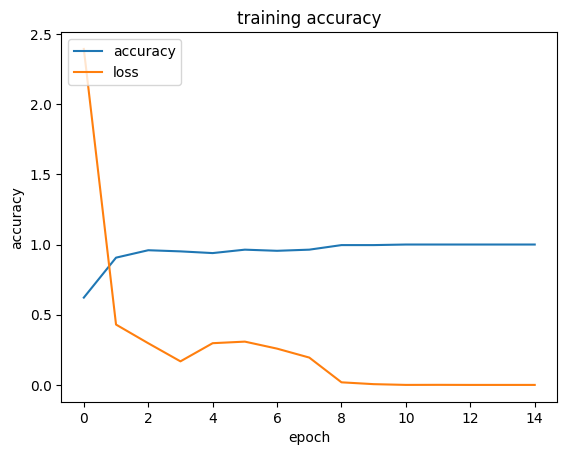

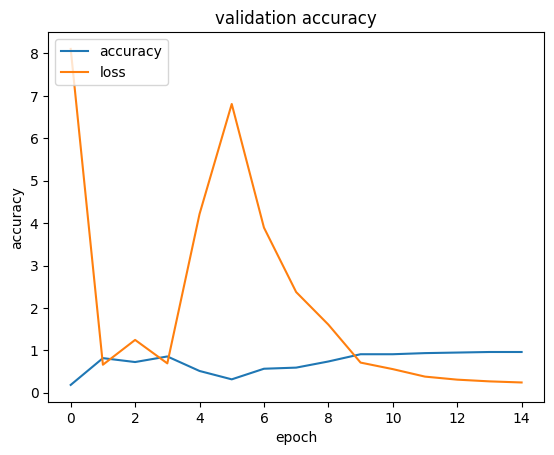

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [16]:
best_model = tf.keras.models.load_model('../h5_files/best_model_Alexnet.h5')

## Test

In [17]:
test_dir = 'D:\CNN-Tim\dataset\\testing'

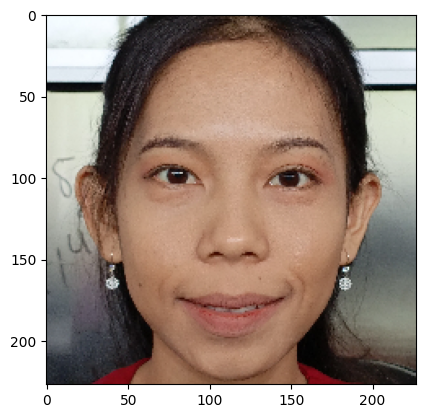

1/1 [==============================] - 0s 289ms/step
['2117051019']


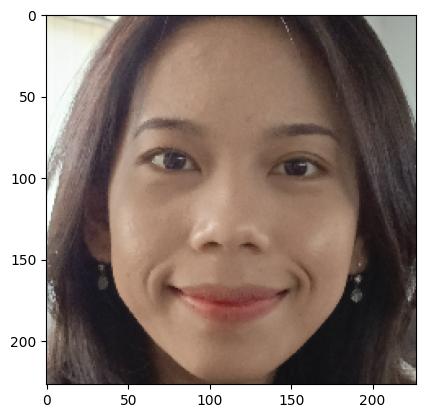

1/1 [==============================] - 0s 56ms/step
['2117051009']


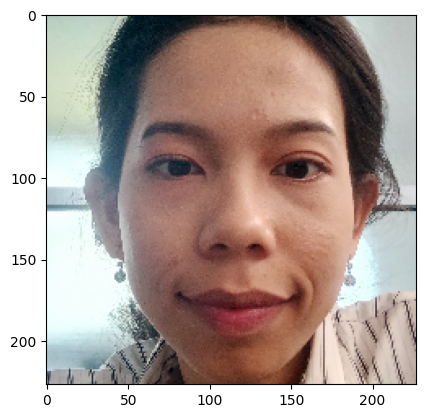

1/1 [==============================] - 0s 58ms/step
['2117051009']


In [18]:
for image in os.listdir(test_dir):
  image_path = os.path.join(test_dir, image)
  image = load_img(image_path, target_size=(227,227))
  plt.imshow(image)
  plt.show()

  x = img_to_array(image)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

  pred = best_model.predict(img)

  predicted_class = np.argmax(pred, axis=1)
  labels = (train_gen.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  predictions = [labels[k] for k in predicted_class]
  print(predictions)
